# Описание проекта

**Заказчик**: Компания «Чётенькое такси» (далее — Заказчик).

**Цель:** спрогнозировать количество заказов такси на следующий час с целью привлечения большего числа водителей в период пиковой нагрузки.  

---

### **План работы:**

1. Загрузка данных и их ресемплирование (по одному часу).
2. Анализ данных.
3. Обучение моделей с различными гиперпараметрами.
4. Проверка данных на тестовой выборке и выводы.


# 0. Подготовка ноутбука к работе

In [543]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from sklearn.dummy import DummyRegressor

In [544]:
# Function to display the main information about a data frame

def display_main_info(df):
    print('________________Head________________')
    display(df.head())
    print('________________Data Types Info________________')
    display(df.info())
    print('________________Shape________________')
    display(df.shape)
    print('________________Proportion of Missing Data________________')
    display(df.isna().mean())

In [545]:
# Function to display statistical info
def show_stats(df, column_name):
    print(f'Statics for {column_name}')
    display(df[[column_name]].describe().T)

In [546]:
def plot_density_and_boxplot(data, column):
    """
    Plot density plot and boxplot for a given column in a DataFrame.

    Parameters:
    - df: pandas DataFrame
    - column: str

    Returns:
    - None
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot density plot
    sns.histplot(data[column], bins=50, color='lightgreen', kde=True, ax=axs[0])
    axs[0].set_title(f'Density Plot of {column}')

    # Plot boxplot
    axs[1].boxplot(data[column], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
    axs[1].set_title(f'Boxplot of {column}')

    # Adjust layout
    plt.tight_layout()

    # Show plot
    plt.show()

# 1. Загрузка данных

In [547]:
df = pd.read_csv(
    'https://taxi.csv',
    index_col=[0],
    parse_dates=[0]
).sort_index()

In [548]:
display_main_info(df)

________________Head________________


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

________________Shape________________


(26496, 1)

________________Proportion of Missing Data________________


num_orders    0.0
dtype: float64

In [549]:
# Проверка, что даты и время расположены в хронологическом порядке.
df.index.is_monotonic_increasing

True

- Всего наблюдений: 26496. Интервал между значениями ряда 10 минут.
- Даты и время расположены в хронологическом порядке.
- Пропусков нет.
- Тип данных корректный.

Необходимо изменение интервала временного ряда, т.к. необходим прогноз на следующий час.

In [550]:
# Ресемплинг, среднее по каждому часу
df = df.resample('1H').mean()

In [551]:
display_main_info(df)

________________Head________________


,num_orders
datetime,
2018-03-01 00:00:00,20.666667
2018-03-01 01:00:00,14.166667
2018-03-01 02:00:00,11.833333
2018-03-01 03:00:00,11.000000
2018-03-01 04:00:00,7.166667


________________Data Types Info________________
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   num_orders  4416 non-null   float64
dtypes: float64(1)
memory usage: 69.0 KB


None

________________Shape________________


(4416, 1)

________________Proportion of Missing Data________________


num_orders    0.0
dtype: float64

- Число наблюдений наблюдений: 4416. Интервал между значениями ряда 1 час.

# 2. Исследование данных

In [552]:
print(df.index.min())
print(df.index.max())

2018-03-01 00:00:00
2018-08-31 23:00:00


In [553]:
show_stats(df, 'num_orders')

Statics for num_orders


,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,14.070463,7.503976,0.0,9.0,13.0,17.833333,77.0


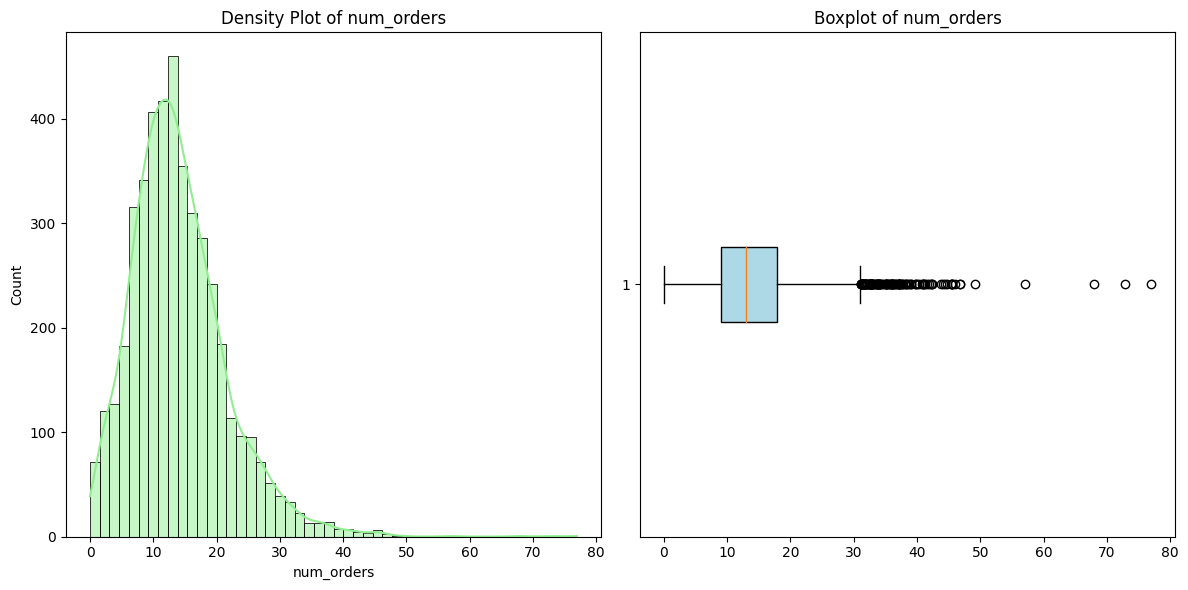

In [554]:
plot_density_and_boxplot(df, 'num_orders')

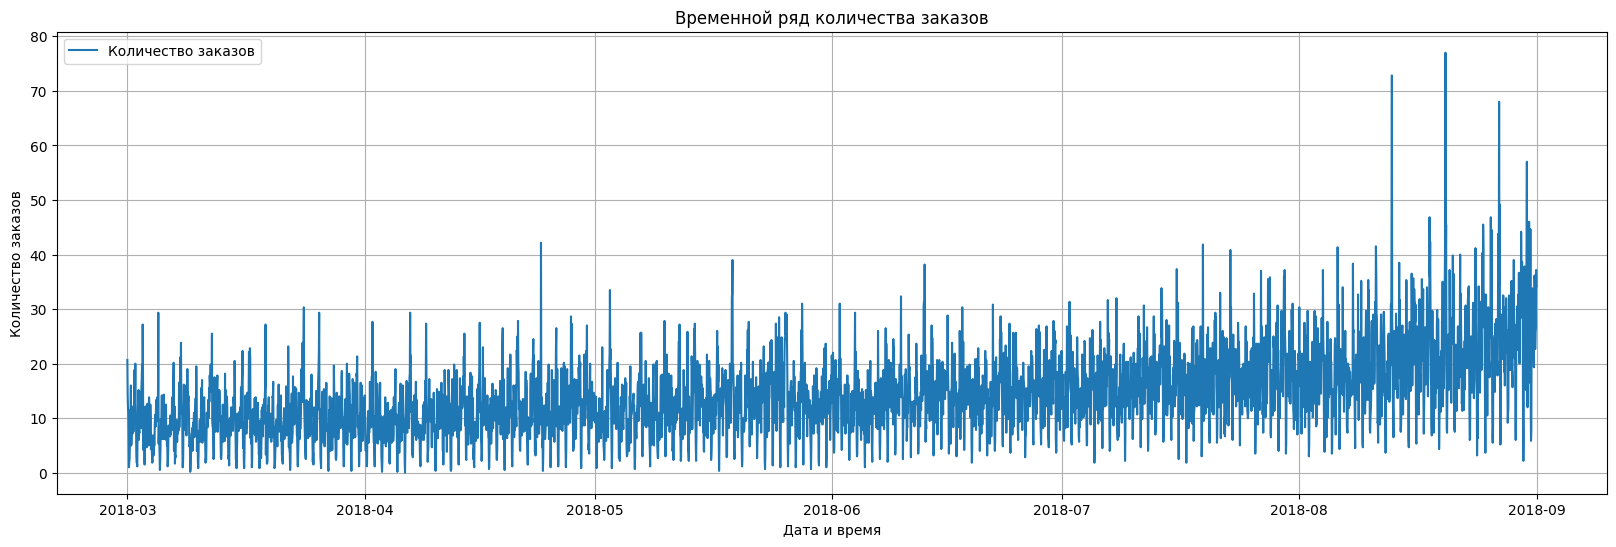

In [555]:
plt.figure(figsize=(20, 6))

plt.plot(df.index, df['num_orders'], label='Количество заказов')
plt.title('Временной ряд количества заказов')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.legend()
plt.grid()
plt.show()

**Наблюдения:**
- В датасете представлены наблюдения с 2018-03-01 по 2018-08-31.
- Распределение числа заказов похоже на лог-нормальное, однако скошенное (предпочтительнее далее использовать модели менее устойчивые к выбросам).
- Среднее число заказов в час 14 +- 7.5.
- Медиана меньше среднего - правый хвост скашивает распределение, т.к. присутствуют наблюдения с высоким числом заказов (60, 70, 80). В какие часы будет ясно далее.

Чтобы лучше понять общую тенденцию изменения количества заказов, исключая шум и случайные всплески, применим скользящее среднее. Размер окна возьмём равный 24 часам.

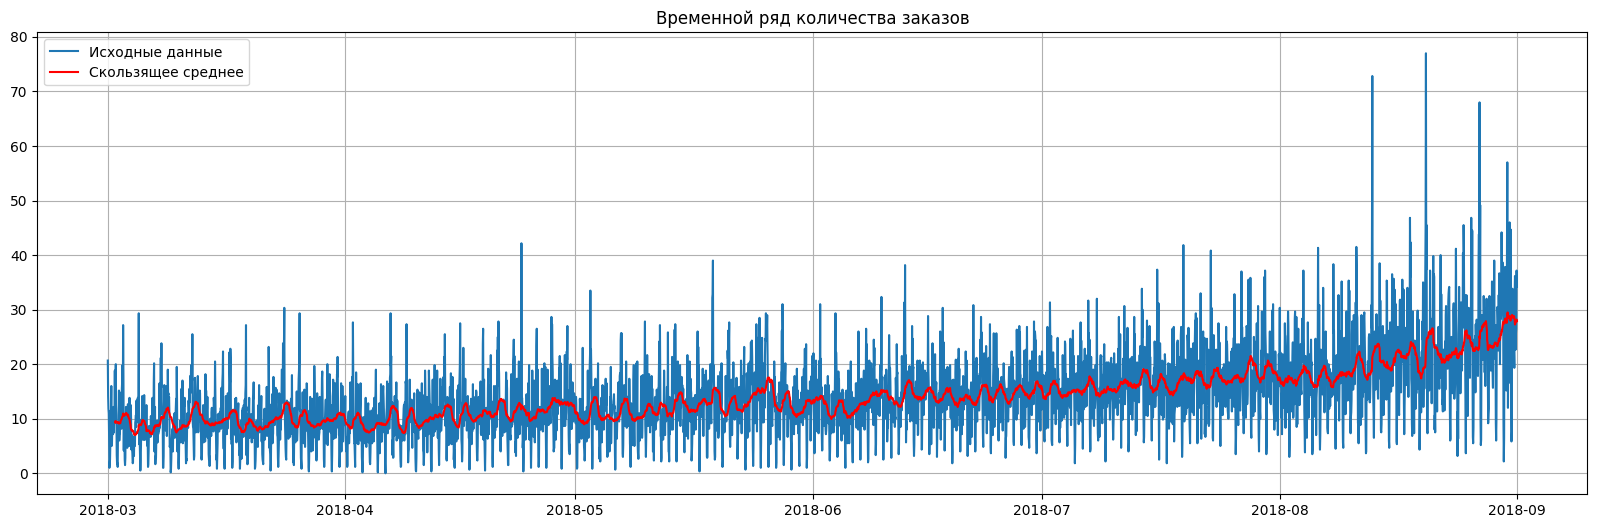

In [556]:
df_ = df.copy()
df_['rolling_mean'] = df_['num_orders'].rolling(window=24).mean()

plt.figure(figsize=(20, 6))
plt.title('Временной ряд количества заказов')
plt.plot(df_['num_orders'], label='Исходные данные')
plt.plot(df_['rolling_mean'], label='Скользящее среднее', color='red')
plt.legend()
plt.grid()
plt.show()

Скользящее среднее растет, это указывает на увеличение количества заказов в долгосрочной перспективе.

**Проверка сезонности.**

Суточная

<Figure size 1200x500 with 0 Axes>

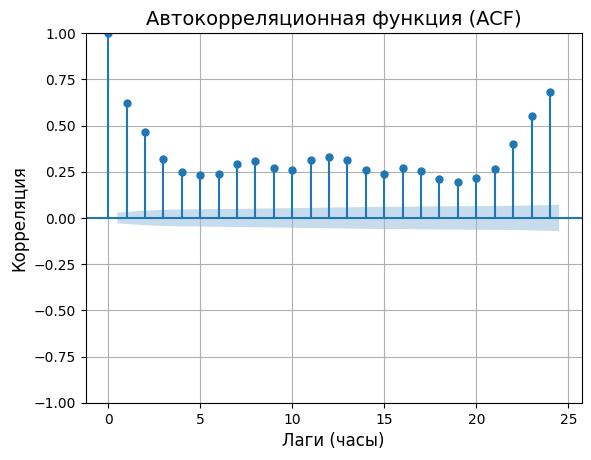

In [557]:
plt.figure(figsize=(12, 5))
plot_acf(df["num_orders"], lags=24)
plt.title("Автокорреляционная функция (ACF)", fontsize=14)
plt.xlabel("Лаги (часы)", fontsize=12)
plt.ylabel("Корреляция", fontsize=12)
plt.grid()
plt.show()

Есть выраженный пик на лаге 24 — это свидетельствует о наличии суточной сезонности. То есть количество заказов такси повторяется примерно с суточным интервалом.
Постепенное снижение автокорреляции говорит о том, что тренд или случайные колебания также влияют на временной ряд.
Дополнительные небольшие пики могут указывать на подциклы внутри суток, например, утренний и вечерний спрос на такси.

Посмотрим график сезонной составляющей за первые сутки.

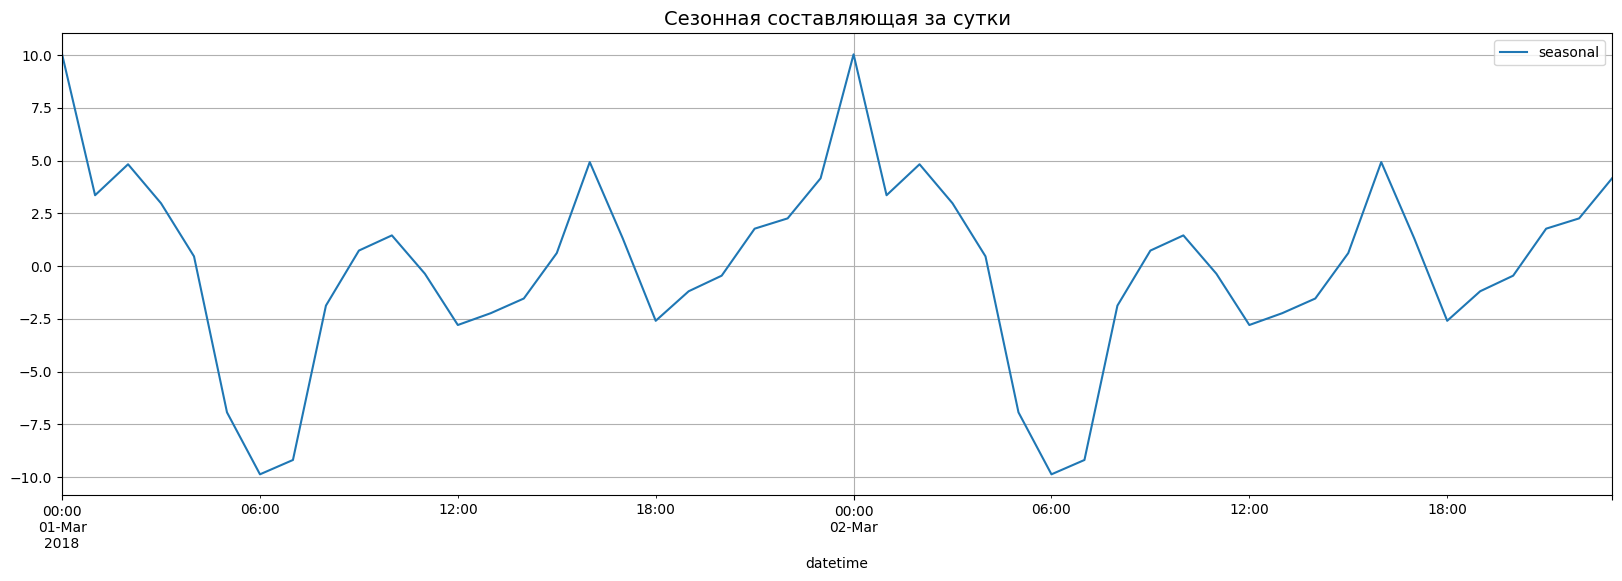

In [558]:
data = df['num_orders']
result = seasonal_decompose(data)

plt.figure(figsize=(20, 6))
plt.title("Сезонная составляющая за сутки", fontsize=14)
result.seasonal['2018-03-01': '2018-03-02'].plot(ax=plt.gca()) 
plt.legend()
plt.grid()
plt.show()

- Четко выраженный суточный цикл

Видно повторяющиеся пики и спады с периодичностью 24 часа. Это подтверждает суточную сезонность спроса на такси.

- Пики утром и вечером — вероятно, это часы пик, когда спрос на такси возрастает (начало и конец рабочего дня).
Минимумы рано утром — когда люди меньше пользуются такси.
- Гармоничность колебаний

Форма сезонного компонента довольно регулярная, без резких выбросов, что говорит о стабильной повторяемости паттерна.

Недельная

<Figure size 1200x500 with 0 Axes>

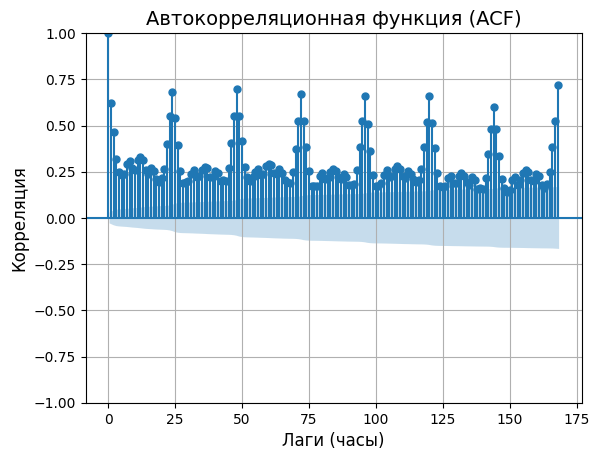

In [559]:
plt.figure(figsize=(12, 5))
plot_acf(df["num_orders"], lags=168)
plt.title("Автокорреляционная функция (ACF)", fontsize=14)
plt.xlabel("Лаги (часы)", fontsize=12)
plt.ylabel("Корреляция", fontsize=12)
plt.grid()
plt.show()

- Четкие пики на лагах 24, 48, 72, 96, 120, 144, 168 часов

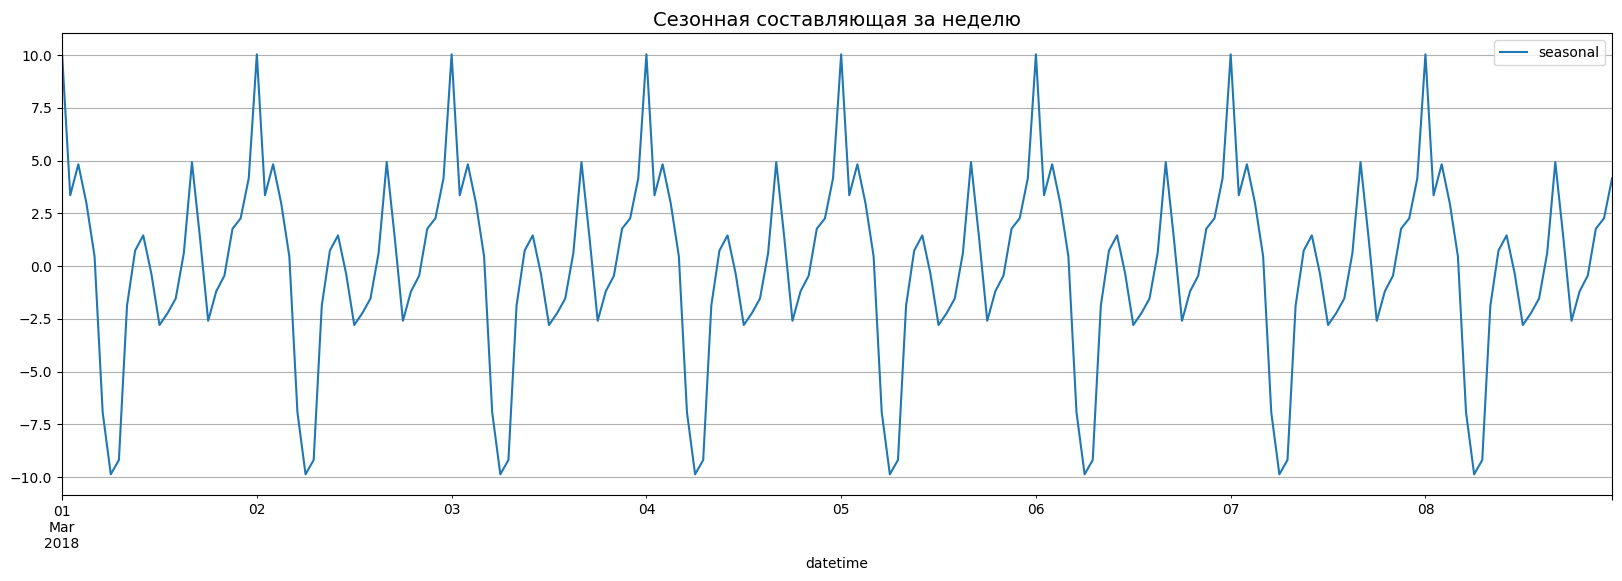

In [560]:
result = seasonal_decompose(data)
plt.figure(figsize=(20, 6))
plt.title("Сезонная составляющая за неделю", fontsize=14)
result.seasonal['2018-03-01': '2018-03-08'].plot(ax=plt.gca()) 
plt.legend()
plt.grid()
plt.show()

Подтверждается суточная сезонность: паттерн повторяется каждые 24 часа.

**Вывод:**

- В датасете представлены наблюдения с 2018-03-01 по 2018-08-31.
- В данных четко прослеживается дневная (24 часа) и недельная (168 часов) сезонность.
- При прогнозировании буду использовать: **лаги 24, 48, 72, 168** часов как признаки.

# 3. Обучение моделей

In [561]:
# Генерация доп. фичей
def make_features(df, target, lags, rolling_mean_size=168):  #скользящее среднее поставлю 168 часов по умолчанию
    
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in lags:
        df[f'lag_{lag}'] = df[target].shift(lag)
    
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    df = df.dropna()
    
    return df

In [562]:
df = make_features(df, 'num_orders', lags=[24, 48, 72, 168])

In [563]:
# итоговый датасет
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4248 non-null   float64
 1   month         4248 non-null   int32  
 2   day           4248 non-null   int32  
 3   dayofweek     4248 non-null   int32  
 4   lag_24        4248 non-null   float64
 5   lag_48        4248 non-null   float64
 6   lag_72        4248 non-null   float64
 7   lag_168       4248 non-null   float64
 8   rolling_mean  4248 non-null   float64
dtypes: float64(6), int32(3)
memory usage: 282.1 KB


In [564]:
# Разделение данных на признаки и таргет

X = df.drop(columns=['num_orders'])
y = df['num_orders']

In [565]:
# Разделение данных на выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)  # 10% тестовая

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

Сначала, взглянем, как поведёт себя линейная регрессия.

In [566]:
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_val)
rmse = root_mean_squared_error(y_val, preds)
rmse

5.07783307113448

Впринципе, не плохо. Попробуем бустинги и ансамбли.

In [567]:
# Функция для метрики
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

In [568]:
# Определение пространства поиска для hyperopt
space = hp.choice('model_type', [
    {
        'type': 'random_forest',
        'n_estimators': hp.choice('rf_n_estimators', range(10, 200)),
        'max_depth': hp.choice('rf_max_depth', range(1, 20)),
        'min_samples_split': hp.choice('rf_min_samples_split', range(2, 20)),
        'min_samples_leaf': hp.choice('rf_min_samples_leaf', range(1, 20)),
    },
    {
        'type': 'gradient_boosting',
        'n_estimators': hp.choice('gb_n_estimators', range(10, 200)),
        'max_depth': hp.choice('gb_max_depth', range(1, 20)),
        'learning_rate': hp.loguniform('gb_learning_rate', np.log(0.01), np.log(0.5)),
        'min_samples_split': hp.choice('gb_min_samples_split', range(2, 20)),
        'min_samples_leaf': hp.choice('gb_min_samples_leaf', range(1, 20)),
    },
    {
        'type': 'xgboost',
        'n_estimators': hp.choice('xgb_n_estimators', range(10, 200)),
        'max_depth': hp.choice('xgb_max_depth', range(1, 20)),
        'learning_rate': hp.loguniform('xgb_learning_rate', np.log(0.01), np.log(0.5)),
        'subsample': hp.uniform('xgb_subsample', 0.5, 1),
        'colsample_bytree': hp.uniform('xgb_colsample_bytree', 0.5, 1),
    }
])

# Функция для оптимизации
def objective(params):
    if params['type'] == 'random_forest':
        model = RandomForestRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=42
        )
    elif params['type'] == 'gradient_boosting':
        model = GradientBoostingRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=42
        )
    elif params['type'] == 'xgboost':
        model = XGBRegressor(
            n_estimators=params['n_estimators'],
            max_depth=params['max_depth'],
            learning_rate=params['learning_rate'],
            subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            random_state=42
        )

    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказание на валидационной выборке
    y_pred = model.predict(X_val)

    # Возвращаем RMSE
    return {'loss': rmse(y_val, y_pred), 'status': STATUS_OK}

# Запуск оптимизации
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# Вывод лучших параметров
print("Лучшие параметры:", best)

100%|██████████| 50/50 [00:38<00:00,  1.31trial/s, best loss: 4.970472566645392]
Лучшие параметры: {'model_type': 2, 'xgb_colsample_bytree': 0.9004778354572854, 'xgb_learning_rate': 0.05331409796792623, 'xgb_max_depth': 2, 'xgb_n_estimators': 163, 'xgb_subsample': 0.6522754463434484}


In [569]:
# Определение лучшей модели на основе лучших параметров
best_model = None  # Инициализация переменной

# Определяем тип модели по значению 'model_type'
if best['model_type'] == 0:
    print("Выбрана модель: RandomForest")
    best_model = RandomForestRegressor(
        n_estimators=best['rf_n_estimators'],
        max_depth=best['rf_max_depth'],
        min_samples_split=best['rf_min_samples_split'],
        min_samples_leaf=best['rf_min_samples_leaf'],
        random_state=42
    )
elif best['model_type'] == 1:
    print("Выбрана модель: GradientBoosting")
    best_model = GradientBoostingRegressor(
        n_estimators=best['gb_n_estimators'],
        max_depth=best['gb_max_depth'],
        learning_rate=best['gb_learning_rate'],
        min_samples_split=best['gb_min_samples_split'],
        min_samples_leaf=best['gb_min_samples_leaf'],
        random_state=42
    )
elif best['model_type'] == 2:
    print("Выбрана модель: XGBoost")
    best_model = XGBRegressor(
        n_estimators=best['xgb_n_estimators'],
        max_depth=best['xgb_max_depth'],
        learning_rate=best['xgb_learning_rate'],
        subsample=best['xgb_subsample'],
        colsample_bytree=best['xgb_colsample_bytree'],
        random_state=42
    )
else:
    raise ValueError("Не удалось определить тип модели по лучшим параметрам.")

# Обучение на всей тренировочной выборке (train + val)
if best_model is not None:
    best_model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
else:
    raise ValueError("Модель не была инициализирована.")

# Предсказание на тестовой выборке
y_test_pred = best_model.predict(X_test)

# Оценка модели на тестовой выборке
test_rmse = rmse(y_test, y_test_pred)
print(f"RMSE на тестовой выборке: {test_rmse}")


Выбрана модель: XGBoost
RMSE на тестовой выборке: 6.467477389176147


Неплохой результат, учитывая стандартное отклонение таргета (7.5)

Сравним с дамми моделью.

In [570]:
# Оценка RMSE для dummy модели
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)
rmse_dummy = np.sqrt(mean_squared_error(y_test, y_pred_dummy))
print(f'RMSE для Dummy модели: {rmse_dummy}')

RMSE для Dummy модели: 14.49850079815488


Метрика для дамми сильно хуже, пожтому, делаем вывод, что XGBoost хорошо справляется с поставленной задачей.

# Вывод

В рамках проекта по предсказанию числа такси на следующий час, была проведена оценка эффективности различных моделей с использованием метрики RMSE.

Dummy модель: Базовая модель, предсказывающая среднее значение числа такси, показала результат RMSE = 14.50. Это значение служит ориентиром для сравнения и демонстрирует эффективность простых методов.

Модель XGBoost: При использовании модели XGBoost был получен результат RMSE = 6.47. Этот показатель значительно улучшает результат базовой модели, обеспечивая более точные предсказания.

Результат, полученный с моделью XGBoost, свидетельствует о высокой эффективности этого подхода для задачи предсказания числа такси. Улучшение показателя RMSE на более чем 8 единиц по сравнению с Dummy моделью подтверждает правильность выбора XGBoost. В дальнейшем можно продолжить оптимизацию модели, исследуя дополнительные гиперпараметры или другие алгоритмы для улучшения точности предсказаний.

Таким образом, модель XGBoost показала отличные результаты и является эффективным инструментом для данной задачи.